<a href="https://colab.research.google.com/github/yeaeunJi/Handson_ML2/blob/master/2%EC%9E%A5_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%B2%98%EC%9D%8C%EB%B6%80%ED%84%B0_%EB%81%9D%EA%B9%8C%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캘리포니아 주택 가격 예측
- 목표 : 인구, 중간 소득 등의 특성을 사용하여 중간 주택 가격 예측
- 모델 : 다중 회귀(여러 개의 설명특성), 
   단변량 회귀(주택 가격 하나만 에측)
- 회귀의 성능 측성 

 ㄱ. 평균 제곱근 오차(RMSE)

 ㄴ. 평균 절대 오차(MAE)


- **x** : 샘플에 대한 특성이 벡터로 표시됨.(여러 개의 값은 굵은 글씨체)
 예) x(i) = 경도
            위도
            중간 소득
            주민
- **X** : 행렬(벡터 x의 전치를 행으로)

 대부분의 샘플은 행에 위치한다고 가정
 특성을 열에 위치
 
- y : 중간 주택 가격(스칼라 값은 보통 글씨체)



**1. 환경 설정**
- 먼저 몇 개의 모듈을 *import함*

In [ ]:
# 파이썬 >= 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >= '0.20'

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 시각화를 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300) :
  path = os.path.join(IMAGE_PATH, fig_id + '.' + fig_extension)
  print('그림 저장 : ', fig_id)
  if tight_layout :
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)
  pass # save_fig

# 불필요한 경고를 무시 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd') 


**2. 데이터 가져오기**


In [ ]:
import os
import tarfile
import urllib.request as request

DOWNLOAD_RROT = 'https://raw.githubusercontent.com/rickiepark/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_RROT + "datasets/housing/housing.tgz"

# 주어진 url에서 데이터 파일을 다운하여 설정한 경로 폴더에 저장하는 함수
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  request.urlretrieve(housing_url, tgz_path)
  houing_tgz = tarfile.open(tgz_path)
  houing_tgz.extractall(path=housing_path)
  houing_tgz.close()
  pass # fetch_housing_data

In [ ]:
fetch_housing_data()

In [ ]:
# 데이터 가공을 위해 임포트
# csv 파일을 읽을 때 가장 많이 사용하는 것 중 하나가 넘파이를 사용하는 것임
# 넘파이가 파이썬에서 csv 파일을 핸들링 할때 가장 편리함

import pandas as pd


# housing.csv 파일을 읽어 데이터 프레임으로 반환하는 함수 
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)
  pass # load_housing_data

In [ ]:
housing = load_housing_data() 
# 데이터 프레임 : 판다스에서 제공하는 다차원 배열 중 하나로 생각하면 됨
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts() # 범주형 특성

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


그림 저장 :  attribute_histogram_plots


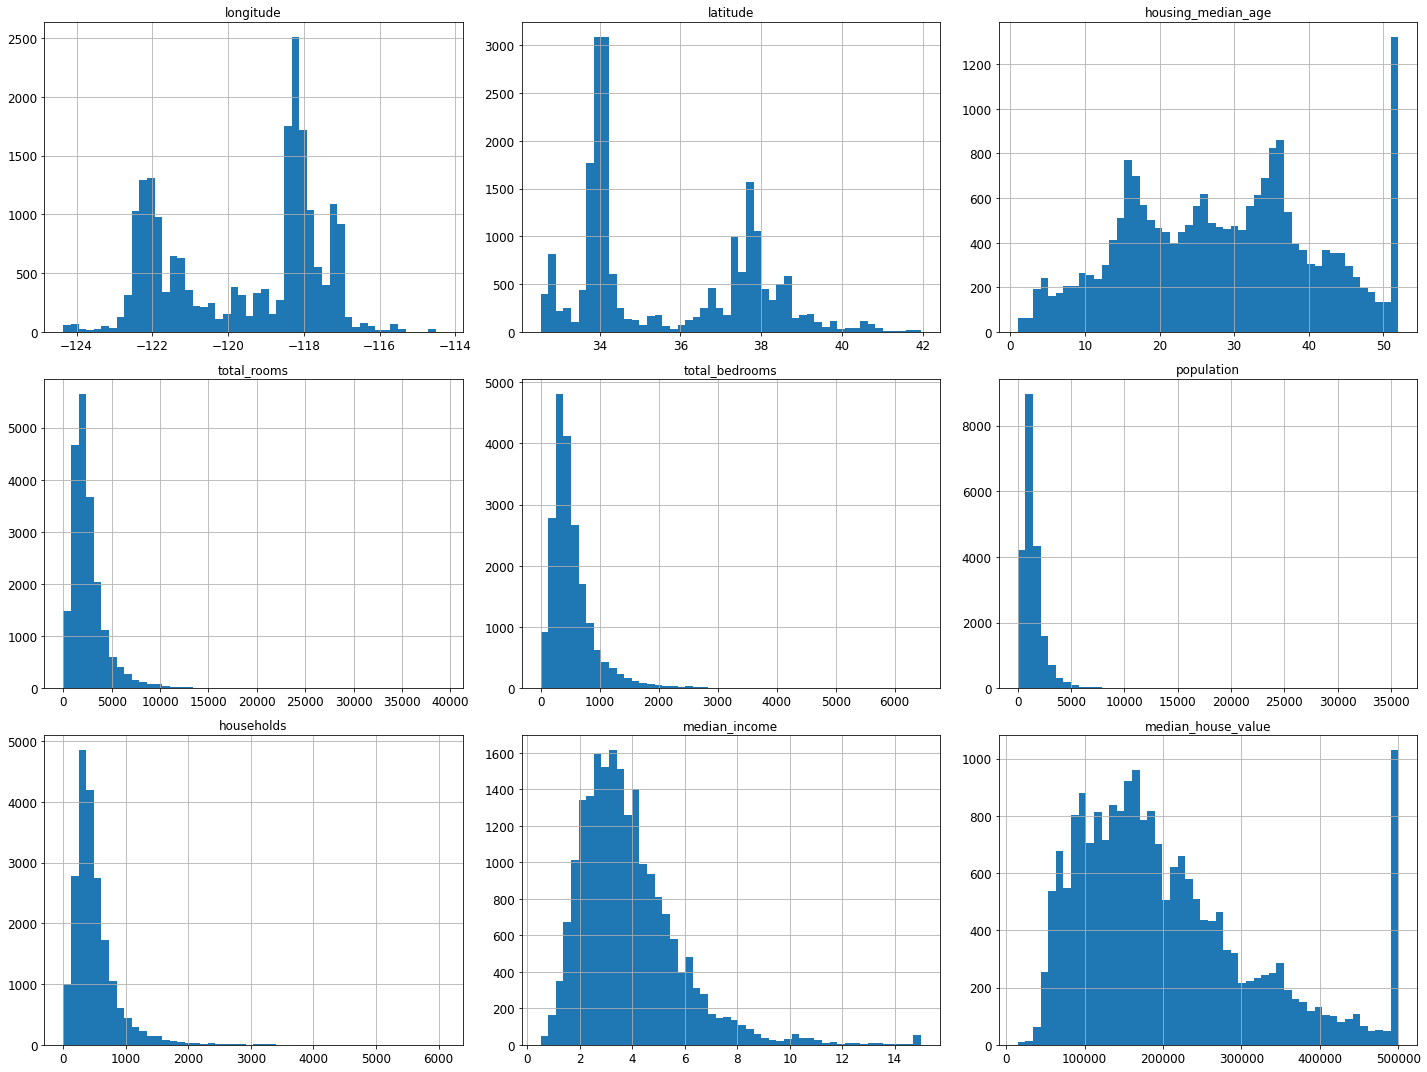

In [ ]:
# 대부분 수치형 특성을 가지고 있으니 히스토그램을 그려 데이터의 분포를 살펴봄
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig('attribute_histogram_plots')
plt.show()

# 그래프들이 대부분 왼쪽으로 치우쳐져 있음 
# => 표준형에 가깝게 변환 필요
# 특정 구간에 이상한 분포(중간 집값 마지막 구간 등) 확인 
# => 이구간 데이터를 제거하거나 그 이상의 데이터를 수집할 필요 있음
# 특성별 스케일이 다름 (10단위인 변수, 십만단위 변수, 천단위 데이터 등 )
# => 단위 스케링일도 필요

In [ ]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42) # 초깃값 지정

**3. 훈련 세트, 테스트 세트 분리**
- 캘리포니아 주택 데이터셋을 다운로드하고 훈련 세트와 테스트 세트로 분할하는 방법을 설명합니다.

In [ ]:
import numpy as np

# 예시로 만든 함수이므로 실전에서는 사이킷런의 train_test_split()을 사용하세요
# 훈련세트와 테스트 세트 분리하는 함수
def split_train_test(data, test_ratio) :
  shuffled_indices = np.random.permutation(len(data)) # 길이만큼의 정수 배열을 섞어서 리턴
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]
  pass # split_train_test

In [ ]:
# 훈련세트와 테스트 세트 분리
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [ ]:
len(test_set)

4128

랜덤 초깃값을 지정해주더라도 간혹 재실행 시 테스트 세트와 훈련 세트가 바뀌게 될 수 있다. 이럴 경우, 테스트 세트에 있던 값이 노출이되면서 과대적합과 같은 일이 일어날 수 있으므로 아래 함수와 같이 그 구분 제한을 더 강하게 만들 수 있다



In [ ]:
from zlib import crc32

# 한번 나눈 테스트 셋은 계속해서 테스트 세트로 사용하도록 하는 함수

# 데이터 샘플에 고유의 값을 해싱하여 체크섬을 만듬
def test_set_check(identifier, test_ratio) :
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32
  pass # test_set_check

def split_train_test_by_id(data, test_ratio, id_columns) :
  ids = data[id_columns]
  in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
  return data.loc[-in_test_set], data.loc[in_test_set]
  pass # split_train_test_by_id

위의 test_set_check() 함수가 파이썬2와 파이썬 3에서 모두 잘 동작.

모든 해시 함수를 지원하고 파이썬2와 파이썬 3에서 사용할 수 있는 함수를 원한다면 다음 함수를 사용하세요

In [ ]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
  return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio
  pass # test_set_check

In [ ]:
housing_with_id = housing.reset_index() 
# housing_with_id.head()
# df.reset_index() : 'index'이름을 열로 추가한 데이터 프레임 반환
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [ ]:
# 경도와 위도의 식별자를 가지고 고유의 값을 만들어서 사용하는 방법
# 주의 ! 고유한 값이 생성이 되지 않을 수도 있으니 유의
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [ ]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


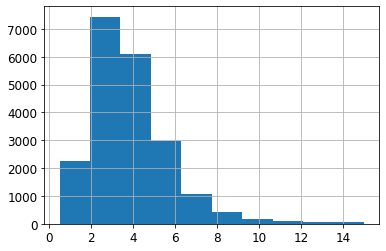

In [ ]:
# 설명 변수 중 하나를 히스토그램으로 분포 파악
housing['median_income'].hist()

# 설명 변수에 해당 하는 중간 수입값이 훈련 세트와 테스트 세트에 고르게 분포되어 있지 않다면 
# 문제가 될 수 있음 ==> 훈련 세트에 고액의 연봉자가 없을 경우 등

In [ ]:
# 연속형 변수는 보기가 어려우므로 이 값을 
# 범주형으로 나누도록 바꿔서 보겠음
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5,  3.0, 4.5, 6., np.inf], # np.inf : 무한대
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

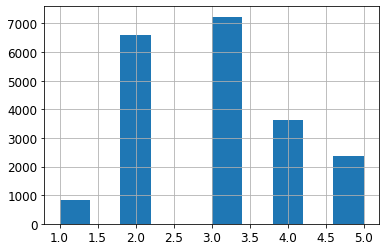

In [ ]:
housing['income_cat'].hist()
# 왼쪽에 편향되었던 분포가 조금 더 종 모양 분포로 바뀌어 나옴

In [ ]:
# 이렇게 나뉘어진  범주별로 고르게 훈련 세트와 테스트 세트로 데이터를 분리하기 위해 아래를 사용
# 층화 무작위 추출(범주형 특성을 고르게 분할하여 데이터 세트 생성)
# 그룹을 분류한다던가 더 복잡하게 층화 추출을 할 경우 사용
from sklearn.model_selection import StratifiedShuffleSplit

# n_splits =1로 지정하면 훈련세트/테스트 세트로 구분됨
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]
  print( strat_train_set['income_cat'].value_counts(), '*')

3    5789
2    5265
4    2911
5    1889
1     658
Name: income_cat, dtype: int64 *


In [ ]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [ ]:
# train_test_split()을 사용하여 층화 무작위 추출을 하기 위해서는
# startify=기준특성으로 설정하면 됨
# 단순한 층화추출을 해당 메소드로 많이 함
st_train_set, st_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])

In [ ]:
st_train_set['income_cat'].value_counts() / len(st_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [ ]:
# 층화추출 결과 비교 함수
def income_cat_proportions(data):
  return data['income_cat'].value_counts() / len(data)
  pass # income_cat_proportion

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame(
    {
        'Overall':income_cat_proportions(housing),
     'Startified': income_cat_proportions(strat_test_set),
     'Random': income_cat_proportions(test_set)
    }).sort_index()

compare_props['Rand. # error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Stat. # error'] = 100 * compare_props['Startified'] / compare_props['Overall'] - 100


In [ ]:
compare_props

,Overall,Startified,Random,Rand. # error,Stat. # error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [ ]:
# 예시를 위해서 만든 income_cat 속성 삭제
for set_ in (strat_train_set, strat_test_set) :
  set_.drop('income_cat', axis=1, inplace=True)

**(4) 데이터 이해를 위한 탐색과 시각화**

- 머신러닝에 사용할 데이터를 만들기 위해 누락된 값을 채우고 필요한 특성을 추가하며 스케일을 조정하는 방법을 배웁니다. 

- 범주형 특성을 원-핫 인코딩으로 바꾸는 방법도 설명합니다. 

- 이 모든 변환을 사이킷런의 파이프라인과 컬럼트랜스포머를 사용해 한번에 처리하는 과정을 학습하겠습니다.

In [ ]:
# 원본 데이터를 훼손하지 않기 위해 데이터 카피
housing = strat_train_set.copy()

그림 저장 :  better_visualization_plot


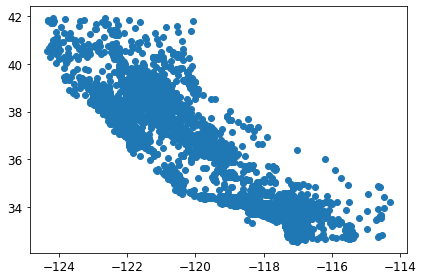

In [ ]:
# housing.plot(kind='scatter', x='longitude', y='latitude')
# housing.plot.scatter( x='longitude', y='latitude') 
# 판다스에서 제공하는 것은 matplotlib을 백그라운드로 사용하여아래와 동일한 그래프 산출
plt.scatter(housing['longitude'], housing['latitude'])
save_fig('better_visualization_plot')

그림 저장 :  better_visualization_plot


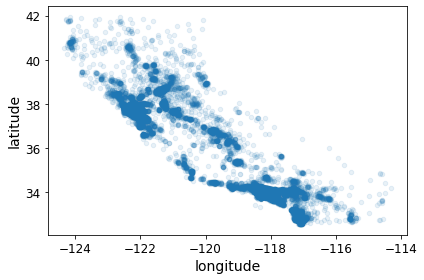

In [ ]:
# 겹치는 데이터가 존재할 경우 뭉개져 보이므로 투명도를 조정한다
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
save_fig('better_visualization_plot')

그림 저장 :  housing_prices_scatterplot


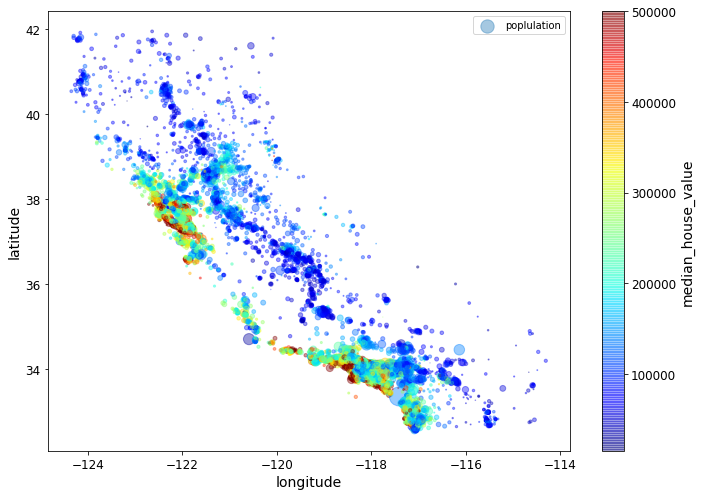

In [ ]:
# 다양한 값을 추가하여 한 그래프에 여러 값을 표시할 수 있다
# 위의 그래프에, 점의 크기를 통해 인구수/100를 표현
# 색을 통해서 중위 집값 표현하고
# plt.get_cmap('jet') : 값이 높은 곳은 빨갛게, 낮은곳은 파랗게 표현하도록 하는 파라미터
# sharex=False 매개변수는 x축의 값과 범위를 표시하지 못하는 버그를 수정하도록 도와주지만 임시방편임
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='poplulation', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False      )
plt.legend() # 범례 표시
save_fig('housing_prices_scatterplot')

# 인구가 많인 지역이면서 주택가도 높은 곳은 원이 크고 빨간 곳이 됨

그림 저장 :  california_housing_prices_plot


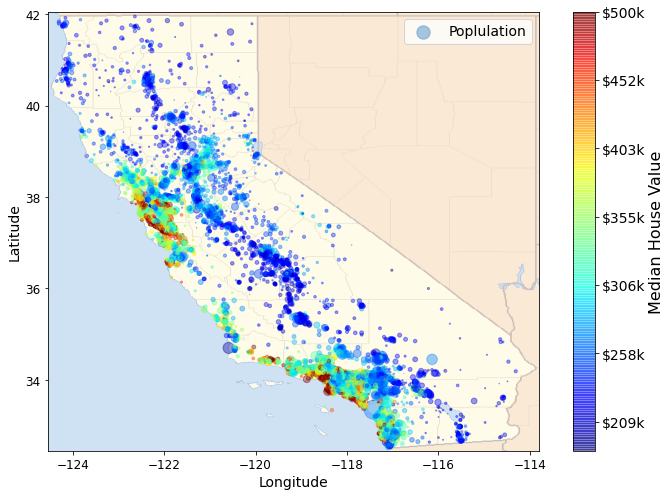

In [ ]:
# 실제 지도 위에 매핑하여 위의 이미지를 시각화

# 캘리포니아 지도 이미지 다운 및 저장
images_path = os.path.join(PROJECT_ROOT_DIR, 'images', 'end_to_end_project')
os.makedirs(images_path, exist_ok=True)

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
filenames = 'california.png'
print('Downloading', filenames)
url = DOWNLOAD_ROOT + 'images/end_to_end_project/'+filenames
request.urlretrieve(url, os.path.join(images_path, filenames))

# 시각화한 산점도를 이미지 위에 덮어씀
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(images_path, filenames))
ax = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='Poplulation', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=False,
             sharex=False      )

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], 
           alpha=0.5, cmap=plt.get_cmap('jet'))

plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=14)
save_fig('california_housing_prices_plot')
plt.show()

In [ ]:
# 각 특성간의 상관 관계를 살펴보기 위해서 상관 계수 행렬 구해보기
corr_matrix = housing.corr()

In [ ]:
# 특성 간 상관 계수를 내림차순으로 정렬하여 살펴봄
# 밀접한 관계가 있을 것으로 판단되는 특성을 추출할 수 있다.
# 피어슨의 상관 계수
# 상관 계수는 선형적인 관계성을 나타낸 것
# -1 : 한 변수의 값이 커질 때 다른 한 변수의 값이 감소되는 패턴
# 1 : 한 변수의 값이 커질때 다른 한 변수의 값도 중가되는 패턴
# 0 : 영상관으로 전혀 관계가 없을 때
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

그림 저장 :  scatter_matrix_plot


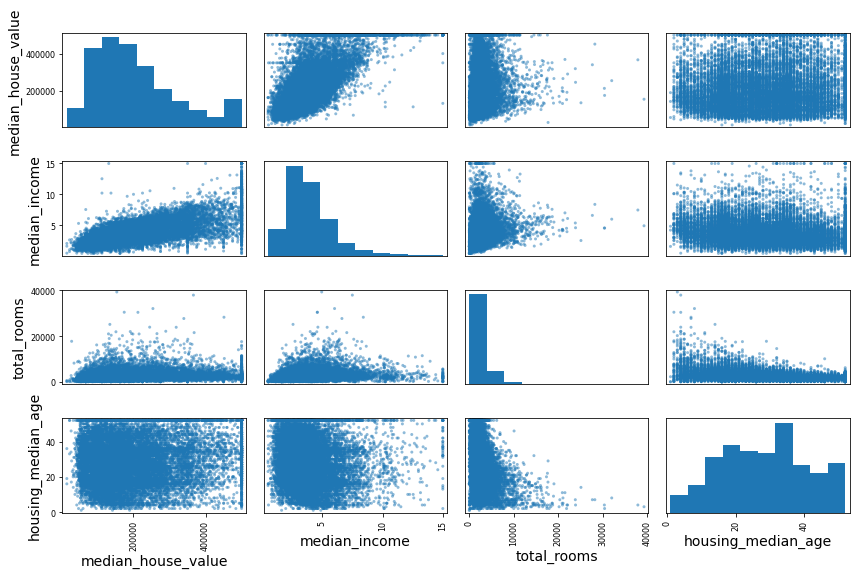

In [ ]:
# from pandas.tools.plotting import scatter_matrix # 옛날 저번 판다스(0.22 버전 이전)
# 몇가지 특성만 선택하여 산점도 행렬을 그림
from pandas.plotting import scatter_matrix

atrributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[atrributes], figsize=(12,8))
save_fig('scatter_matrix_plot')

그림 저장 :  income_vs_house_value_scatterplot


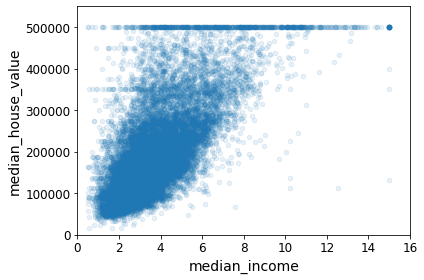

In [ ]:
# 추측할 변수인  median_house_value 와 선형적 관계가 나타난 median_income 을 조금 더 자세하게 살펴좀
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

plt.axis([0, 16, 0, 550000])
save_fig('income_vs_house_value_scatterplot')

# 특정 지점에서 직선이 경향성 확인
# 최댓값이 500000으로 되어 있으므로 유의

In [ ]:
# 파생 변수 생성하기
# 전체 방의 수보다는 각 주택별 방의 수가 더 의미 있을 것으로 생각하고 관련 파생 변수를 생성
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [ ]:
# 상관 행렬 시각화
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

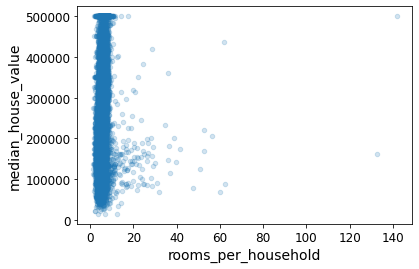

In [ ]:
# rooms_per_househoold 산점도
housing.plot(kind='scatter', x='rooms_per_household', y='median_house_value', alpha=0.2)
plt.show()
# 직선보다는 약간 기울어진 경향 확인 가능


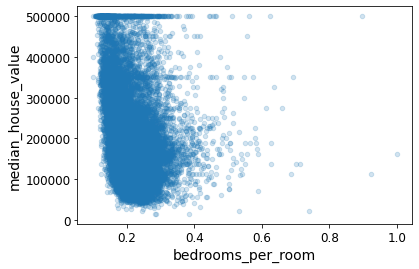

In [ ]:
# bedrooms_per_room 산점도
housing.plot(kind='scatter', x='bedrooms_per_room', y='median_house_value', alpha=0.2)
plt.show()

In [ ]:
# 이 파생변수 3가지가 조금 도움이 될 것 같다는 인사이트를 얻음
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


**(5) 머신러닝 알고리즘을 위한 데이터 준비**

In [ ]:
# 예측 변수 값을 빼서 설명 변수만 담은 것과, 예측 변수 값을 가진 데이터로 구분
housing = strat_train_set.drop('median_house_value', axis=1) 
housing_labels = strat_train_set['median_house_value'].copy()

In [ ]:
# 결측치가 존재하는 열 존재 확인
sample_incomplete_rows = housing[ housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
# 결측치 처리 방법 옵션 1
# dropna를 사용하여 결측치 행 삭제
sample_incomplete_rows.dropna(subset=['total_bedrooms'])
# subset을 주지 않으면 전체 데이터 프레임에 대해 수행
# 디폴트 값으로 axis=0이므로 행 단위로 삭제된다
# axis=1로 설정하면 결측치가 하나라도 있으면 해당 열을 삭제한다.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [ ]:
# 결측치 처리 방법 옵션 2
# drop을 사용하여 행 또는 열 삭제(결측치를 판단하지 않고 그냥 설정한 값을 삭제)
# 디폴트 값으로 axis=0이므로 행 단위로 삭제된다
# axis=1로 설정하면 해당 열을 삭제한다.
sample_incomplete_rows.drop('total_bedrooms', axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
# 결측치 처리 방법 옵션 3
# 결측치 임퓨테이션(대체)
# 디폴드로 inplace=False로 새로운 데이터 프레임을 반환하지만
# inplace=True이면 기존 데이터 프레임의 결측치가 대체됨
median = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace=True)

In [ ]:
# 결측치 처리 방법 옵션 4
# 사이킷런의 전처리 도구 중 하나를 사용하여 결측치 처리하는 방법
# 다른 사이킷런의 도구들과 결합하여 사용할 수 있으므로 편리
from sklearn.impute import SimpleImputer
imputer= SimpleImputer(strategy='median') # mean, most_freqeunt(최빈값), constant(임의로 지정한 값)

In [ ]:
# 위에서 중간값으로 결측치를 대체하도록 하였는데 중간값이 수치형 데이터에서만 
# 계산될 수 있으므로 텍스트형 특성을 삭제해준다
housing_num = housing.drop('ocean_proximity', axis=1)
# 다른 방법 : housing_num = housing.select_dtype(include=[np.number ])

In [ ]:
# 생성한 impute 적용
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
imputer.statistics_ # 각 특성별 계산된 중앙값 확인 가능

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
# 각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

#### 훈련 세트 변환 시작

In [ ]:
X = imputer.transform(housing_num) # X에 변환된  numpy 배열 반환

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # 넘파이 배열을 데이터프레임으로 변환

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [ ]:
imputer.strategy
# imputer.statistics_ 와 같이 끝에 _가 붙어 있는 경우, 사이킷런의 함수가 학습한 결과를 보여주는 속성이고
# imputer.strategy와 같이 없는 경우에는 학습에 사용한 파라미터를 담고 있다.

'median'

In [ ]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [ ]:
#  범주형 입력 특성인 ocean_proximity 전처리
housing_cat = housing[['ocean_proximity']]
# hosuing['ocean_proximity']로 받을 경우, 시리즈로 반환되어 불편할 수 있음
# 따라서 중괄호를 사용하여 데이프레임 형식으로 반환받음

housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [ ]:
# 이러한 데이터를 바꾸는 방법에는 사이킷런에서는 크게 2가지 존재
# 옵션 1 OrdinalEncoder
# 문자열 데이터를 정수형 데이터로 바꿔줌
from sklearn.preprocessing import OrdinalEncoder


ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


# 하지만 이렇게 변환할 경우, 0 ~ 4 사이의 값이 크고 작음이 없는 개념임에도
# 분석 결과가 값의 크기에 영향을 받을 수 있음

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# 위와 같은 문제를 예방하기 위해서 범주형 특성을 바꾸는 대표적인 인코딩 방식이 존재
# 옵션 2 OneHotEncoder
# 각 범주의 값을 하나의 변수로 만들어서 0,1값 할당
# 기본적으로 희소 행렬을 반환(희소행렬이란 대체로 0인 값을 가진 행렬)
# 필요하면 toarray() 메소드를 사용해 밀집 배열로 변환 가능
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
# 또는 OneHotEncoder를 만들때 sparse=False로 지정하여 희소행렬이 아닌 객체로 반환받을 수 있다.
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# 위에서 추가하기로 했던 파생변수는 판다스로 만들 것이었는데
# 판다스로 작성된 것을 사이킷런의 함수를 사용 할때 등에 통합하는데에 귀찮을 수 있다
# 따라서 사이킷런 도구를 사용하여 추가 특성을 위한 사용자 정의 변환기를 만들어봄

from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombineAttributesAdder(BaseEstimator, TransformerMixin ):
  def __init__(self, add_bedrooms_per_room = True) :  # *args 또는 **kargs 없음
    self.add_bedrooms_per_room = add_bedrooms_per_room
    pass # initializer

  def fit(self, X, y=None) : # 아무것도 하지 않습니다
    return self
    pass # fit

  def transform(self, X) :
    rooms_per_households = X[:, rooms_ix] / X[:, households_ix]
    population_per_households = X[:, population_ix] / X[:, households_ix]

    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X,rooms_per_households, population_per_households, bedrooms_per_room]

    else :
      return  np.c_[X,rooms_per_households, population_per_households]

    pass # transform
pass # CombineAttributesAdder

attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns = list(housing.columns) + ['rooms_per_household', 'population_per_household'],
    index = housing.index
    )

housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


**수치형 특성을 전처리하기 위한 파이프라인 생성하기**

In [ ]:
# 대부분의 머신러닝 모델들은 거리가 모델 학습에 영향을 미치는 경우가 많아서 '거리'를 중요하게 생각한다.
# 어떤 특성은 데이터 값의 스케일이 100~1000이고, 어떤 특성은 0.1~1이면 거리 계산에 왜곡이 발생할 수 있다.
# 따라서 데이터 스케일을 맞추는 것을 권장

# 많이 사용하는 스케일러는 StandardScaler이다. 
# StandardScaler : 데이터에서 그 열의 평균을 빼고 그 열의 표준편차를 나눠서 표준점수로 바꾸는 역할
# => 평균이 1이고 표준편차가 0인 데이터로 스케일링 됨
# 파이프라인 : 여러 개의 추정기나 변환기를 통하여 하나의 변환기 및 예측기처럼 사용할 수 있는 사이킷런의 도구

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipline = Pipeline([
                        ('imputer' ,  SimpleImputer(strategy='median')),
                        ('attr_adder', CombineAttributesAdder()),
                        ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [ ]:
# 범주형 데이터를 만들었던 내용과 위에서 작성한 파이프라인을 다시 한번 합칠 수 있음
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
                                  ('num', num_pipline, num_attribs), # num_pipline은 num_attribs에 있는 컬럼에만 적용하겠다는 의미
                                  ('cat', OneHotEncoder(), cat_attribs),

])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(16512, 16)

**다음은 판다스의 데이터프레임에서 각 열의 일부에 다른 파이프라인을 적용하기 위해서 만든 예전 방식이다. 이전에는 ColumnTransformer를 제공하지 않았으므로 아래와 같이 함수를 만들어 사용해볼 수 있었다.**


In [ ]:
# DataFrameSelector 변환기와 FeatureUnion을 사용한 예전 방식

from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin) :
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
    pass # initializer

  def fit(self, X, y=None):
    return self
    pass # fit 

  def transform(self, X) :
    return X[self.attribute_names].values
    pass # transform   
  pass # OldDataFrameSelector

In [ ]:
# 하나의 파이프라인에 이들을 모두 결함하여 수치형과 범주형 특성을 전처리하기
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

old_num_pipeline= Pipeline(
    [
     ('selector', OldDataFrameSelector(num_attribs)),
     ('imputer' ,  SimpleImputer(strategy='median')),
     ('attr_adder', CombineAttributesAdder()),
     ('std_scaler', StandardScaler()),
    ]
)

old_cat_pipeline =  Pipeline(
    [
     ('selector', OldDataFrameSelector(cat_attribs)),
     ('cat_encoder', OneHotEncoder(sparse=False)),
    ]
)

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
         ('num_pipeline', old_num_pipeline),
         ('cat_pipeline', old_cat_pipeline),
  ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

**(6) 모델 선택과 훈련**
- 머신러닝 모델을 만들고 교차 검증과 그리드 서치로 최적의 모델을 찾는 과정을 설명합니다.
- 7장에서 배울 랜덤포레스트도 살짝 알아보겠습니다.

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해봄
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('예측:', lin_reg.predict(some_data_prepared))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [ ]:
# 실제 값과 비교
print('레이블:', list(some_labels)) # 실제값과 차이가 좀 존재하긴 함

레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [ ]:
from sklearn.metrics import mean_squared_error # 평균제곱오차
# MSE : 예측값과 실제값의 차이의 제곱의 합의 평균
# 제곱된 값이기때문에 루트를 씌어서 제곱근으로 살펴봄(RMSE)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

68628.19819848923

In [ ]:
# 평균 절댓값 오차도 구해볼 수 있음
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print(lin_mae)

# 또는 적합시킨 회귀 모델의 성능예측을 위한 정확도 점수를 통해서 확인 가능
lin_reg.score(housing_prepared, housing_labels) # 결정계수 r-squared 값이 반환됨
# 결정 계수 : 1 - (타깃-예측)*2/(타깃-타깃평균)*2
# 1에 가까울수록 예측을 잘하는 것이고 0이되면 평균정도를 예측하는 수준
# 현재 이 값이 0.64이면 좋지 않은 점수임
# ==> 과소적합된 모델

49439.89599001897


0.6481624842804428

In [ ]:
# 결정 트리 모델 
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse) # 과대 적합 발생

tree_reg.score(housing_prepared, housing_labels) # 과대 적합

# 훈련 세트에 너무 완벽한 모델은 테스트 세트에서 점수가 낮을 수 있다
# 만약 테스트 세트 점수와 훈련 세트 점수가 차이가 크면 과대적합

0.0


1.0

그렇지만 너무 테스트 세트를 자주 사용하여 값을 맞추다보면 테스트 세트가 노출되어 일반화가 어려워질 수 있다. 따라서 다음 교차검증과 같은 방법을 통해 테스트 세트를 덜 사용한 검증을 수행해볼 수 있다.

**(7) 모델 세부 튜닝**

In [ ]:
from sklearn.model_selection import cross_val_score
# 훈련 세트를 cv 수만큼 등분하여 한 세트를 제외한 나머지로 훈련하고 성능을 평가하여
# 각 에포크별 점수를 반환해주는 교차 검증 방법
# 예) cv = 3이면 훈련 세트를 3등분하여 2,3번 세트로 훈련하고 1번 세트로 검증(1에포크),
# 1,3번째 세트로 훈련하고 2번째 세트로 검증(2에포크), 
# 1,2번째 세트로 훈련하고 3번째 세트로 검증(3에포크)
# 이렇게 나온 검증 점수를 평균내서 최종 성능 척도로 검사
# 이러한 덩어리를 '폴드'라고 부르고 k개의 폴드를 만들어서 교차검증하므로
# 이러한 교차검증을 'k-fold 교차검증'이라고 부름

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                          scoring = 'neg_mean_squared_error', cv=10)
# scoring 파라미터 : 회귀 모델이기 때문에 기본적으로 mse를 사용하지만 
# neg_mean_squared_error는 음수의 mse를 의미.
# ==> 사이킷런은 기본적으로 점수가 높은 것을 좋은것이라고 가정한다. 하지만
#     mse같은 경우, 값이 높을수록 모델의 성능이 좋지 않다는 것이므로 
#     음수로 만들어서 평가에 활용
#     예) -123이 -12보다 작은 값이므로 값이 높을수록 모델의 성능이 좋다는 것으로 생각 가능

# 대신 이렇게 계산된 값을 출력할 때에는 다시 양수로 변환하여 확인해줘야함
tree_rmse_scores = np.sqrt(-scores) 

In [ ]:
# 교차 검증으로 반환된 넘파이 배열을 평균, 표준편차, 점수 값으로 반환되도록 하는 함수
# parameter 
# scores : 교차 검증 결과로 반환된 넘파이 배열
# return
# 없음
def display_scores(scores):
  print('점수 : ', scores)
  print('평균 : ', scores.mean())
  print('표준편차 : ', scores.std())
  pass # display_scores

display_scores(tree_rmse_scores)

점수 :  [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
평균 :  71407.68766037929
표준편차 :  2439.4345041191004


In [ ]:
# 선형 회귀 모델에도 k fold 교차검증 수행
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)

pd.Series(np.sqrt(-scores)).describe()

# lin_rmse_scores = np.sqrt(-lin_scores)

# display_scores(lin_rmse_scores)


count       10.000000
mean     71407.687660
std       2571.389745
min      66855.163639
25%      70265.554176
50%      70937.310637
75%      72132.351151
max      75585.141729
dtype: float64

**교차 검증의 필요성**

교차 검증을 수행하지 않고 훈련 세트를 적합시킨 트리 모델의 점수는 100% 예측으로 좋아보였는데 교차 검증을 수행하니 검증 세트의 점수는 거의 차이가 없거나 트리 모델이 조금 더 나쁘게 나왔다. 

또한, 테스트 세트를 사용하지 않고 훈련 세트를 쪼개서 검증하고 있다.


**(8) 랜덤포레스트**

핸즈온 7장에서 배우겠지만 트리 모델을 사용한 앙상블모델이 있다.

앙상블이란 여러 개의 트리 모델을 사용하여 그 예측들을 평균내거나 하는 모델로 신경망을 제외하고 가장 강력한 머신러닝 중 하나

그중 대표적인 것이 랜덤포레스트인데 살펴보도록 하겠다

- 사이킷런의 랜덤포레스트는 n_estimators로 지정된 k만큼의 결정 트리를 만들어서 훈련 후 그 결과를 앙상블에서 평균내어 적용
- 특징 : 각 트리마다 중복을 허용한 무작위 샘플링하여 훈련세트를 만들어서 트리를 하나씩 훈련

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 객체 생성 및 훈련 데이터 학습
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# 훈련시킨 랜덤 포레스트 모델로 예측
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse # 18603.515021376355 위에서보다 확실히 값이 줄어듬

18603.515021376355

In [ ]:
from sklearn.model_selection import cross_val_score

# 랜덤포레스트 모델에 대해 k-fold 교차 검증 수행
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring='neg_mean_squared_error', cv=10)

# 교차 검증으로 반환된 mse의 제곱근인 rmse 구하기
forest_rmse_scores = np.sqrt(-forest_scores)

# 교차 검증 결과인 rmse 점수 표출
display_scores(forest_rmse_scores) 

점수 :  [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균 :  50182.303100336096
표준편차 :  2097.0810550985693


In [ ]:
# 서포트 벡터 모델을 빠르게 시험해보고 
# 가장 좋은 성능을 보인 몇개의 모델을 선택하여 튜닝작업 실시할 것임

# SVR은 서포트벡터 머신의 회귀 모델
# SVC는 서포트벡터 머신의 분류 모델
from sklearn.svm import SVR

# SVR 모델 생성 
svm_reg = SVR(kernel='linear')

# SVR 모델 학습
svm_reg.fit(housing_prepared, housing_labels)

# SVR 모델 예측
housing_predictions = svm_reg.predict(housing_prepared)

# SVR 모델의 RMSE
svm_reg_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_reg_mse)
svm_rmse

111094.6308539982

In [ ]:
# 성능 최적화를 위해 여러번의 파라미터 수정을 고치는 작업을
# 편리하게 제공해주는 사이킷런의 최적화 도구
from sklearn.model_selection import GridSearchCV

# 자동으로 수행할 파라미터 지정
# dict 형식으로 검색하고 싶은 파라미터 조합을 입력
param_grid = [
    # 12(=3*4)개의 하이퍼파라미터 조합을 시도
    # 사용할 모델에 적용할 하이퍼파리미터(모델 생성 파라미터 : 12개의 모델, 12개의 교차검증)
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    # bootstrap은 False로 지정하고 6(=2*3)개의 조합 시도
    # bootstrap 매개변수는 기본값이 True인데 랜덤하게 샘플 추출하는 것에 관한 하이퍼 파라미터
    {'bootstrap' : [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)

# 다섯 개의 폴드로 훈련하면 총 (12+6)*5 = 90번의 훈련이 일어남
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, # 5번의 교차검증
                           scoring='neg_mean_squared_error',
                           return_train_score=True) # 훈련 스코어에 대한 정보 

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
# 최상의 파라미터 조합은 다음과 같다
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# 그리드서치에서 테스트한 하이퍼파라미터 조합의 점수 확인
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres['mean_test_score'], cvres['params']) :
  print(np.sqrt(-mean_score), param)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.076726,0.003033,0.004609,0.000079,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,-4.196408e+09,-3.903319e+09,-4.184325e+09,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.243242,0.002074,0.012078,0.000152,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,-3.130196e+09,-2.865188e+09,-3.173856e+09,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.732360,0.006975,0.033316,0.000285,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,-2.948330e+09,-2.619995e+09,-2.970968e+09,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.121496,0.002234,0.004518,0.000145,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,-3.734515e+09,-3.418747e+09,-3.913907e+09,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.399907,0.001741,0.012013,0.000242,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,-2.892276e+09,-2.616813e+09,-2.948207e+09,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.192940,0.010131,0.033905,0.001070,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,-2.666426e+09,-2.398071e+09,-2.649316e+09,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.164066,0.004388,0.004470,0.000061,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,-3.592772e+09,-3.328934e+09,-3.579607e+09,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.548250,0.007030,0.011900,0.000115,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,-2.762720e+09,-2.521134e+09,-2.907667e+09,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.672391,0.026662,0.033958,0.001641,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,-2.607703e+09,-2.350953e+09,-2.661059e+09,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.209844,0.002773,0.004567,0.000119,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,-3.402843e+09,-3.129307e+09,-3.510047e+09,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [ ]:
# 탐색할 파라미터 수가 많거나 파라미터 값이 연속된 숫자인 경우
# 사이킷런의 RandomizedSearchCV를 사용할 수 있다.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators' : randint(low=1, high=200),
    'max_features' : randint(low=1, high=8),
}
# n_iter=10 만큼 파라미터를 탐색
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, param in zip(cvres['mean_test_score'], cvres['params']) :
  print(np.sqrt(-mean_score), param)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances
# 트리 모델의 장점은 특성의 중요도를 개선할 수 있다는 것
# 트리 모델의 앙상블도 이러한 특성을 제공하고 있음.

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
# 이러한 특성을 보기 좋게 변경
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
# cat_encoder = cat_pipline.named_steps('cat_encoder') # 예전 방식

cat_encoder = full_pipeline.named_transformers_['cat'] # 파이프라인에서 부여한 명칭으로 찾음
cat_one_hot_attirbs = list(cat_encoder.categories_[0]) # 여러개의 변수에 대해 원핫인코딩을 수행한 경우 인덱스별로 각 변수들의 범주가 들어가있음

attributes = num_attribs + extra_attribs + cat_one_hot_attirbs
# print(len(attributes))
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [ ]:
# 최적의 파라미터를 사용하여 최적의 모델을 만들고 테스트 세트로 테스트
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_text_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_text_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927

In [ ]:
# 테스트 RMSE에 대한 95% 신뢰 구간 계산하기
from scipy import stats

confidence = 0.95 # 신뢰수준
squared_errors = (final_predictions - y_test) ** 2 # 모든 샘플에 대한 제곱오차
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors))) # 표준 오차 함수
# 판다스 시리즈에서 제공하는 sem() 동일
# squared_errors.std() / np.sqrt(len(squared_errors))도 동일

array([45685.10470776, 49691.25001878])

In [ ]:
# 다음과 같이 수동으로도 계산 가능
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) /2 , df = m-1)
tmargin = tscore *  squared_errors.std(ddof=1) / np.sqrt(m) 
# 판다스 시리즈, 데이터프레임함수의 ddof 자유도에서 차감될 값을 의미. 기본값 = 1
# 넘파이메소드에서는 기본값이 0이므로 유의
np.sqrt(mean-tmargin), np.sqrt(mean+tmargin)

(45685.10470776, 49691.25001877858)

In [ ]:
# 또는 t-scpre대신 z-score도 사용 가능
zscore = stats.norm.ppf((1+confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean-zmargin), np.sqrt(mean+zmargin)

(45685.717918136455, 49690.68623889413)

**추가 내용**

전처리와 예측을 포함한 전체 파이프라인

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ('preparation', full_pipeline),
        ('linear', LinearRegression()),
])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)
# 전체 파이프라인에서 predict를 호출하면 변환기에 transform메소드 호출,
# 모델의 predict 메소드도 호출

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

joblib을 사용한 모델 저장

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
# pickle파일로 객체를 저장
joblib.dump(my_model, 'my_model.pkl') # DIFF
my_model_loaded = joblib.load('my_model.pkl') # DIFF

RandomizedSearchCV를 위한 Scipy 분포 함수

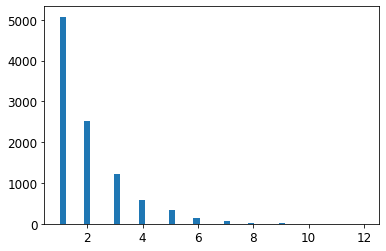

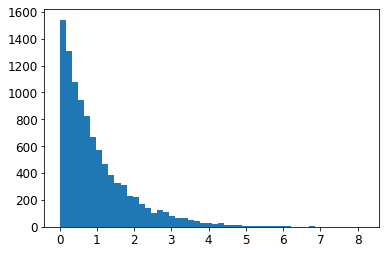

In [ ]:
# randint로 무작위 정수 추출 대신 다른 확률 분포를 사용해볼 수 있음
from scipy.stats import geom, expon

# 기하 분포 : 확률이 0.5일때 10000개 정도 추출
# 비연속적
geom_distrib = geom(0.5).rvs(10000, random_state=42)

# 지수 분포 : 스케일(1/lambda)을 1로 넣어주고 10000개 추출
# 연속적
expon_distrib = expon(scale=1).rvs(10000, random_state=42)

# 시각화
plt.hist(geom_distrib, bins=50)
plt.show()

plt.hist(expon_distrib, bins=50)
plt.show()
